## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from scipy import signal
plt.style.use('seaborn-colorblind')
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA

## Création des données pour la classification

In [3]:
def cree_labels(features, liste_transitions, liste_labels):
    #il faut bien avoir assez de label sinon on renvoie une erreur
    #liste_transitions.append(len(features))
    labels = np.zeros(len(features))
    past_index = 0
    current_index = 0
    for k in range(len(liste_transitions)) :
        current_index = liste_transitions[k]
        labels[past_index : current_index] = liste_labels[k]
        past_index = current_index
    labels[liste_transitions[-1] : len(features)] = liste_labels[len(liste_transitions)]
    return labels

Ci dessous les leviers sur lesquels jouer pour réaliser une classification. On entre le nom du jeu de données de train, de test. on choisit la taille n du filtre pour smooth les enregistrements, la longueur de la fenêtre sur laquelle on construit nos features pour les données de train et de test. liste_labels contient dans l'ordre les labels des classes par lesquelles on passe dans l'enregistrement de test, par exemple [0, 1, 0] si je suis assis puis je marche puis je suis assis. Dans liste_transition, on note les numeros des points de l'enregistrement où l'on switch d'une activité à l'autre, par exemple, si j'ai enregistré 22000 points et que j'ai changé d'activité au 8000ème point puis au 14000ème point, je prend [8000, 14000].


Il reste ensuite à choisir des features qui expliquent bien les données, pour l'instant on utilise seulement la variance sur une fenêtre et l'écart max à la valeur médiane sur la fenêtre pour l'accélération sur l'axe vertical et pour l'accélération dans le plan horizontal (norme des deux coordonnées dans ce plan). Cela fait quatre variables explicatives. 

In [19]:
window_length = 500
n = 50
train_name = 'adrien_balade.csv'
test_name = 'adrien_balade.csv'
liste_labels = [0, 1] # 0 c'est assis bus, 1 c'est sinus bus, 2 c'est marche
liste_transitions = [11730]

In [20]:
def create_train(train_name, window_length, n, liste_labels, liste_transitions):
    data = pd.read_csv(train_name, engine = 'python')
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    for k in range(arrX.shape[0] // window_length):
        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[k * window_length : (k+1) * window_length].mean()
        yg = arrY[k * window_length : (k+1) * window_length].mean()
        zg = arrZ[k * window_length : (k+1) * window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))
        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))
        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[k * window_length : (k+1) * window_length], filteredY[k * window_length : (k+1) * window_length], filteredZ[k * window_length : (k+1) * window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    labels = cree_labels(fdata, liste_transitions, liste_labels).astype(int)
    train_features = [[], [], [], []]
    labels_idee = []
    for k in range(len(liste_windows)):
        labels_idee.append(np.argmax(np.bincount(np.array(labels[k * window_length : (k+1) * window_length]))))
        train_features[0].append(np.var(liste_windows[k][0, :]))
        train_features[1].append(np.var(liste_windows[k][1, :]))
        train_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        train_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
    train_features = np.transpose(np.array(train_features))
    train_features = train_features[3 : -3, :]
    labels_idee = labels_idee[3 : -3]
    return train_features, labels_idee

In [21]:
def create_test(test_name, window_length, n):
    data = pd.read_csv(test_name, engine = 'python')
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    for k in range(arrX.shape[0] // window_length):
        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[k * window_length : (k+1) * window_length].mean()
        yg = arrY[k * window_length : (k+1) * window_length].mean()
        zg = arrZ[k * window_length : (k+1) * window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))
        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))
        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[k * window_length : (k+1) * window_length], filteredY[k * window_length : (k+1) * window_length], filteredZ[k * window_length : (k+1) * window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    test_features = [[], [], [], []]
    for k in range(len(liste_windows)):
        test_features[0].append(np.var(liste_windows[k][0, :]))
        test_features[1].append(np.var(liste_windows[k][1, :]))
        test_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        test_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
    test_features = np.transpose(np.array(test_features))
    test_features = test_features[3 : -3, :]
    return test_features

## Classification

/home/vincent/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/vincent/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/vincent/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/vincent/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/vincent/anacon

prediction sur le train, juste pour voir


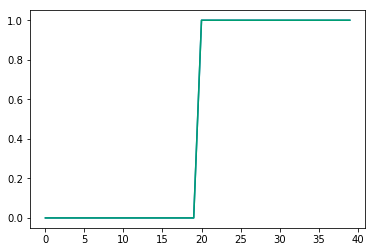

prediction sur le test
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


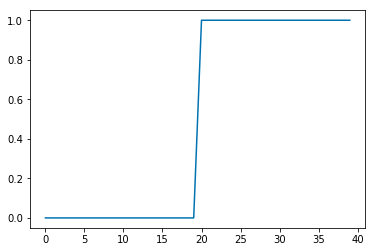

In [22]:
train_features, labels_idee = create_train(train_name, window_length, n, liste_labels, liste_transitions)
test_features = create_test(test_name, window_length, n)
#train, classes = pd.DataFrame(features_idee), labels_idee
train, classes = pd.DataFrame(train_features), labels_idee
scaler = preprocessing.RobustScaler().fit(train) # ou StandardScaler
train_scaled = scaler.transform(train)
pca = PCA(svd_solver = 'randomized', n_components = 4)
train_scaled_pca = pca.fit_transform(train_scaled)

test = pd.DataFrame(test_features)
test_scaled = scaler.transform(test)
test_scaled_pca = pca.transform(test_scaled)

clf = BaggingClassifier(MLPClassifier(solver = 'adam', alpha = 1, max_iter = 200, shuffle = True, hidden_layer_sizes = (100, 100, 100)), n_estimators = 10, max_samples = 0.5)
rf = RandomForestClassifier(n_estimators = 10)
dt = DecisionTreeClassifier(min_samples_leaf = 10)

clf.fit(train_scaled_pca, classes)
rf.fit(train_scaled_pca, classes)
dt.fit(train, classes)
prediction_clf = clf.predict(train_scaled_pca)
prediction_rf = rf.predict(train_scaled_pca)
prediction_dt = dt.predict(train_scaled_pca)
prediction = np.rint(np.array((prediction_rf + prediction_rf + prediction_dt)/3.))
print('prediction sur le train, juste pour voir')
plt.figure()
plt.plot(prediction)
plt.plot(labels_idee)
plt.show()


prediction_clf = clf.predict(test_scaled_pca)
prediction_rf = rf.predict(test_scaled_pca)
prediction_dt = dt.predict(test_scaled_pca)
print('prediction sur le test')

prediction = np.rint(np.array((prediction_rf + prediction_rf + prediction_dt)/3.))
print(prediction)
plt.figure()
plt.plot(prediction)
plt.show()

## Mise en forme des résultats

In [31]:
print('Prédiction :')
etat_courant = prediction[0]
temps = 0
for etat in prediction:
    if etat == etat_courant:
        temps = temps + 0.005 * window_length
    else:
        print('On est resté dans l etat ', etat_courant, ' pendant ', temps, ' secondes')
        temps = 0
        etat_courant = etat
print('On est resté dans l etat ', etat_courant, ' pendant ', temps, ' secondes')

Prédiction :
On est resté dans l etat  0.0  pendant  50.0  secondes
On est resté dans l etat  1.0  pendant  47.5  secondes
